In this tutorial, we are going to go through an image classification example using MLPs on the MNIST digits dataset. You'll need to have keras installed to follow along.

In [1]:
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Loading the data
First, we will load the MNIST dataset (this will download the dataset the first time you run it). MNIST is a popular dataset in machine learning. Each sample is a single channel (i.e., grayscale) 28x28 (the size in pixels) image representing a hand-written digit. There 10 classes, for the digits 0, 1, ... , 9.

In [44]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('train input shape: {}'.format(x_train.shape))
print('train labels shape: {}'.format(y_train.shape))
print('test input shape: {}'.format(x_test.shape))
print('test labels shape: {}'.format(y_test.shape))

train input shape: (60000, 28, 28)
train labels shape: (60000,)
test input shape: (10000, 28, 28)
test labels shape: (10000,)


We can see that there 60k training samples and 10k test samples. It is always a good practice to inspect a dataset first before you starting using it. Check the size, the range of values for the input and output, and visualize a few samples.

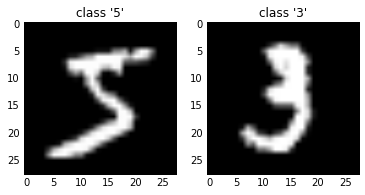

In [45]:
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title("class '{}'".format(y_train[0]))
plt.subplot(1, 2, 2)
plt.imshow(x_train[10], cmap='gray')
plt.title("class '{}'".format(y_train[10]))

In [46]:
print(x_train.min(), x_train.max())

0 255


We can see that the range of values for the input is 0-255. This is important to know. If you are using a pre-trained model, you want to know what normalization was used on the input and use the same. Moreover, your training and test data should be normalized in the same way.

We usually nomralize images to take values in the range 0-1 (or sometimes to have zero mean and unit variance).

In [47]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
print(x_train.min(), x_train.max())

0.0 1.0


Also a good idea to inspect the format of the labels. Sometime, they are given as integers (as in this case), sometimes as one-hot encoded vectors.

In [48]:
print(y_train[:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


So, we can see that each label is just an integer. Since we are going to train an MLP where the final layer is a softmax (whose output can be thought of as a probability distribution), we should convert our labels to one-hot encoding (some machine learning libraries will do this automatically for you, so always check the API).

In [49]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
print(y_train.shape)
print(y_test.shape)
print(y_train[0])

(60000, 10)
(10000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


We can see that each label now is 10-dimensional one-hot encoded vector. The label for the first training sample, which was '5', is shown.

It is easy to revert back to the original labels if you need them, by finding the position of the maximum values across the columns.

In [52]:
print(np.argmax(y_train[:20], axis=1))

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


## Defining the MLP model
Now that the data is in the format we want, let's build our model. We will use keras Sequential API. Let's build an MLP with 2 hidden layers. MLPs have fully connected layers (as opposed to, say, convolutional layers), sometimes also called dense layers.

There are many parameters that we can pass in defining a Dense layer in keras. The first layer should define the expected input shape (in our case 28x28=784, the *flattened* image size). Moreover, we need to specify the number of units/neurons in each layer. Finally, we can also specify an acitivation function to use.

In [240]:
mlp = Sequential()
mlp.add(Dense(64, activation='sigmoid', input_shape=(784,)))
mlp.add(Dense(64, activation='sigmoid'))

So, we've added our 2 hidden layers, each with 64 units and a sigmoid non-linearity. Now we need to add the output layer. As we said, the output layer is a softmax over 10 classes, so it needs to contain 10 units, and the activation has to be softmax.

In [241]:
mlp.add(Dense(10, activation='softmax'))

With this, the network construction is complete. What's left, is to specify the optimization process: what loss function are we trying to minimize, and what optimizer do we want to use. To do this, we need to *compile* the model. We can also specify metrics such as accuracy to monitor during training, but they have no effect on the optimization.

The loss depends on the problem we are trying to solve. For multi-class classification it is called categorical_crossentropy in keras.

We will use the Adam optimizer with the default parameters. It is a variant of gradient descent.

In [242]:
mlp.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

## Training the model
We can begin now training.

Suppose our training set is made of 200 samples only. Let's begin training with that and train for 100 epochs.

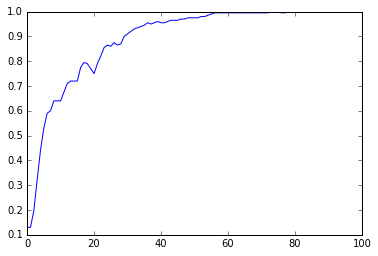

In [243]:
h = mlp.fit(x_train[:200].reshape(-1, 28 * 28), y_train[:200],
            epochs=100, batch_size=32, verbose=0)
plt.plot(h.history['acc'])

Very quickly, we reach an accuracy of 100%. You may be tempted to think that your model is good and it can perform well on future data. However, this accuracy is on the training data, and it may not be representative of test accuracy. This can happen for different reasons (mismatch between training and test distributions, limited data, overfitting, etc.)

When training a model, what you need to be monitoring is the loss/accuracy on a held-out set, called the validation set. So, let's evaluate our model on the test set to see how it does there.

In [244]:
print('test accuracy: {}%'.format(100 *
                                  mlp.evaluate(x_test.reshape(-1, 28 * 28),
                                               y_test)[1]))

10000/10000 [==============================] - 1s 59us/step
test accuracy: 75.3%


We see that the model does poorly on the test set compared to the training set. The reason in this case is that we did not use enough training data. So let's use the whole training set, and this time let's use 25% of the training set as a validation set to monitor performance. (This could take a while to run, depending on your setup.)

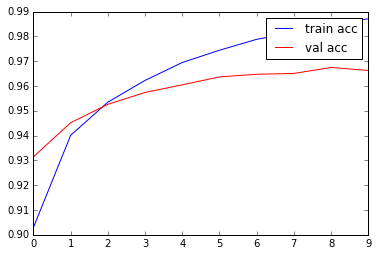

In [245]:
h = mlp.fit(x_train.reshape(-1, 28 * 28), y_train, epochs=10,
            batch_size=32, validation_split=0.25, verbose=0)
plt.plot(h.history['acc'])
plt.hold('on')
plt.plot(h.history['val_acc'], 'r')
plt.legend(['train acc', 'val acc'])

Let's now evaluate again on our test set.

In [246]:
print('test accuracy: {}%'.format(100 *
                                  mlp.evaluate(x_test.reshape(-1, 28 * 28),
                                               y_test)[1]))

10000/10000 [==============================] - 0s 27us/step
test accuracy: 96.89%


So we can see that the validation accuracy is a better estimate of the test accuracy.

In some cases, a model could be overfit the training data. You can idenitfy this situation if you notice your training accuracy increasing while the validation accuracy is decreasing. Adding more training data is one way to counter this issue, but that is not always feasible.

Another approach is to simplify your model: if your model is a very high capacity (many layers/units) while your data is limited, you are probably going to overfit.

To see this in action, let's look at this toy regression example.

## Overfitting
Suppose the input is 2-dimensional (x_1, x_2) and that y=3x_1 + 2x_2 + n, where n is some random noise. Let's generate 100 samples from this model.

In [227]:
x = 6 * np.random.rand(100, 2) - 3
y = 3 * x[:, 0] + 2 * x[:, 1] + 2 * np.random.randn(100,)

Let's build an MLP for this regression problem. We will follow the same steps, with few differences.

In [228]:
mlp = Sequential()
mlp.add(Dense(1024, activation='relu', input_shape=(2,)))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer='adam')

In [229]:
h = mlp.fit(x, y, epochs=3000, batch_size=100,
            validation_split=0.5, verbose=0)

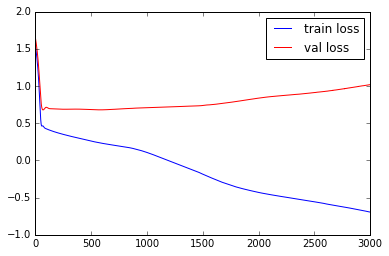

In [231]:
plt.plot(np.log10(h.history['loss']))
plt.hold('on')
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])

Note how the validation goes down at first, and then starts to go back up. This is an indication of overfitting. One way to counter this (aside from adding more data), is to use *early stopping*: stop training when the validation loss begins to increase.

Another approach, as we mentioned earlier, is to simplify our model, say by reducing the number of units from 1024 to 64.

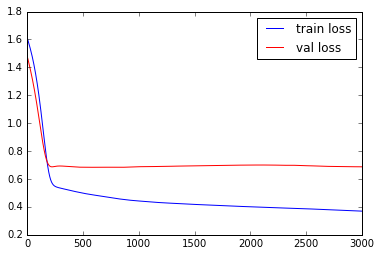

In [232]:
mlp = Sequential()
mlp.add(Dense(64, activation='relu', input_shape=(2,)))
mlp.add(Dense(1, activation='linear'))
mlp.compile(loss='mean_squared_error', optimizer='adam')
h = mlp.fit(x, y, epochs=3000, batch_size=100, validation_split=0.3, verbose=0)
plt.plot(np.log10(h.history['loss']))
plt.hold('on')
plt.plot(np.log10(h.history['val_loss']), 'r')
plt.legend(['train loss', 'val loss'])